# Rust Unstable Feature Analysis (v3)

This notebook summarizes the sampling pipeline and visualizes the CSV outputs generated by `analyze_features.py` for `features_head_v3.db`.

What you need:
- Python 3.9+
- `pandas`, `matplotlib`, `seaborn` (install with `pip install pandas matplotlib seaborn` if missing)
- CSVs in `analysis_outputs/`: `feature_head_summary.csv`, `feature_history_summary.csv`, `feature_lifetimes.csv`, `category_summary.csv`
- Optional: raw tables in `features_head_v3.db` for deeper joins.

Sampling background (v3):
- Two-layer sampling from crates.io dump:
  - **Core stratum**: top N by reverse dependencies (N=300) + optional core list.
  - **Non-core stratum**: filter by downloads >=100 and latest year >=2015, then stratify by (top_category, popularity_band) using p50/p90 downloads.
- Only GitHub repos are kept; duplicate owner/repo collapsed (pick higher revdeps/downloads).
- Target size: 1500 repos; final unique GitHub repos: 1500.

This notebook first re-summarizes sampling outputs (ratios by core/non-core, categories), then visualizes nightly feature usage.

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sqlite3
from datetime import datetime

# Optional: load sampled CSV to recompute sampling stats
SAMPLE_CSV = Path("sampled_crates_v3.csv")
DB_PATH = Path("features_head_v3.db")

sns.set_theme(style="whitegrid")
BASE = Path("analysis_outputs")

head_df = pd.read_csv(BASE / "feature_head_summary.csv")
hist_df = pd.read_csv(BASE / "feature_history_summary.csv")
life_df = pd.read_csv(BASE / "feature_lifetimes.csv")
cat_df = pd.read_csv(BASE / "category_summary.csv")

sample_df = None
if SAMPLE_CSV.exists():
    sample_df = pd.read_csv(SAMPLE_CSV)

conn = None
if DB_PATH.exists():
    conn = sqlite3.connect(DB_PATH)


head_df.head(), hist_df.head(), life_df.head(), cat_df.head()

(      feature_name  head_repo_count
 0          doc_cfg              137
 1             test               84
 2     doc_auto_cfg               24
 3    allocator_api               12
 4  core_intrinsics                8,
    feature_name  ever_repo_count
 0          test              155
 1       doc_cfg              131
 2  doc_auto_cfg               71
 3        plugin               69
 4          core               68,
              feature_name  num_repos  num_still_present  num_retired  \
 0                   Serde          2                  0            2   
 1                _preview          1                  0            1   
 2                       a          2                  0            2   
 3  aarch64_target_feature          1                  0            1   
 4            abi_thiscall          1                  1            0   
 
          min_first_seen_date        max_first_seen_date  \
 0  2017-10-22T22:46:17+00:00  2017-10-22T22:57:00+00:00   
 1  2018-07-

## 1) Sampling recap
- Core vs non-core composition
- Top categories by sample size
- HEAD vs EVER nightly ratios for core/non-core

Sample size: 1500 (core=300, non-core=1200)


/var/folders/p5/wq68nkrn7q78rwt1d8kzlygr0000gn/T/ipykernel_58149/2878694226.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_cats, x="count", y="top_category", ax=axes[0], palette="viridis")
/var/folders/p5/wq68nkrn7q78rwt1d8kzlygr0000gn/T/ipykernel_58149/2878694226.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cat_df_sorted, x="head_nightly_ratio", y="category", ax=axes[1], palette="rocket")


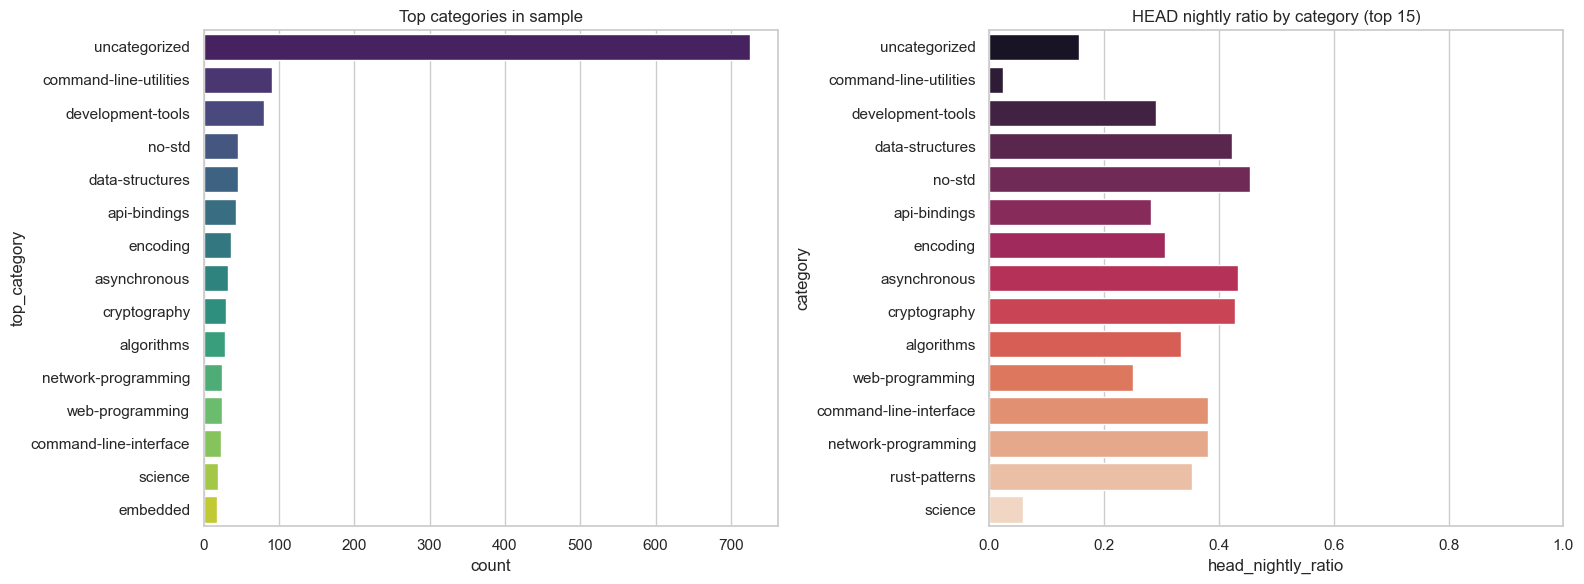

In [55]:
if sample_df is not None:
    # Basic counts
    total = len(sample_df)
    core = sample_df[sample_df["is_core"] == 1]
    noncore = sample_df[sample_df["is_core"] == 0]
    print(f"Sample size: {total} (core={len(core)}, non-core={len(noncore)})")

    # Category sizes
    top_cats = sample_df["top_category"].value_counts().head(15).reset_index()
    top_cats.columns = ["top_category", "count"]

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.barplot(data=top_cats, x="count", y="top_category", ax=axes[0], palette="viridis")
    axes[0].set_title("Top categories in sample")

    # Core vs non-core ratio of HEAD/EVER nightly (join with cat_df ratios is coarse; here use cat_df aggregated)
    cat_df_sorted = cat_df.sort_values("total_repos", ascending=False).head(15)
    sns.barplot(data=cat_df_sorted, x="head_nightly_ratio", y="category", ax=axes[1], palette="rocket")
    axes[1].set_title("HEAD nightly ratio by category (top 15)")
    axes[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()
else:
    print("sampled_crates_v3.csv not found; skip sampling recap.")

## 2) Feature usage overview
- Distribution of HEAD vs EVER usage counts per feature
- Identify dominant gates

/var/folders/p5/wq68nkrn7q78rwt1d8kzlygr0000gn/T/ipykernel_58149/2310721705.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_long, x="avg_lifetime_days", y="feature_name", ax=axes[1], palette="magma")


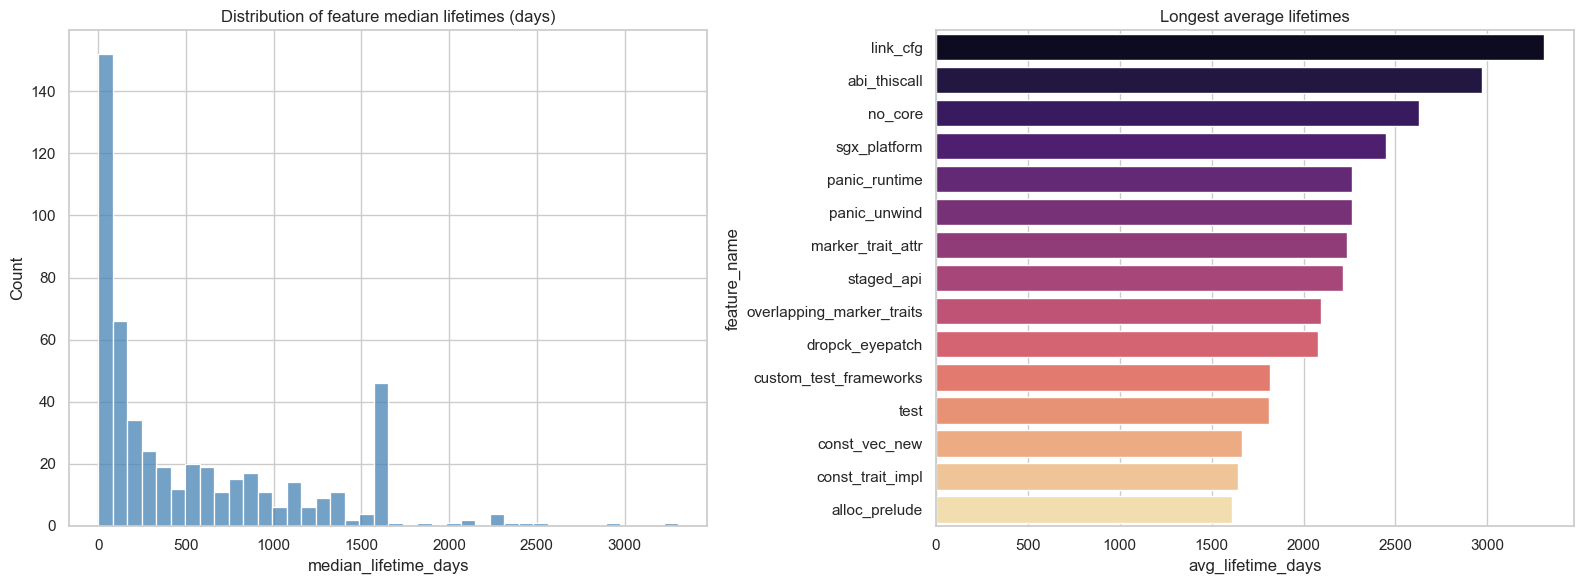

In [56]:
life_df["avg_lifetime_days"] = pd.to_numeric(life_df["avg_lifetime_days"], errors="coerce")
life_df["median_lifetime_days"] = pd.to_numeric(life_df["median_lifetime_days"], errors="coerce")
life_df["num_repos"] = pd.to_numeric(life_df["num_repos"], errors="coerce")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(life_df["median_lifetime_days"].dropna(), bins=40, ax=axes[0], color="steelblue")
axes[0].set_title("Distribution of feature median lifetimes (days)")

top_long = life_df.dropna(subset=["avg_lifetime_days"]).nlargest(15, "avg_lifetime_days")
sns.barplot(data=top_long, x="avg_lifetime_days", y="feature_name", ax=axes[1], palette="magma")
axes[1].set_title("Longest average lifetimes")
plt.tight_layout()
plt.show()

## 4) Retention vs adoption
- Still-present ratio = num_still_present / num_repos
- Compare with coverage to spot "sticky" gates


/var/folders/p5/wq68nkrn7q78rwt1d8kzlygr0000gn/T/ipykernel_58149/2288233386.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_ratio, x="still_ratio", y="feature_name", palette="crest")


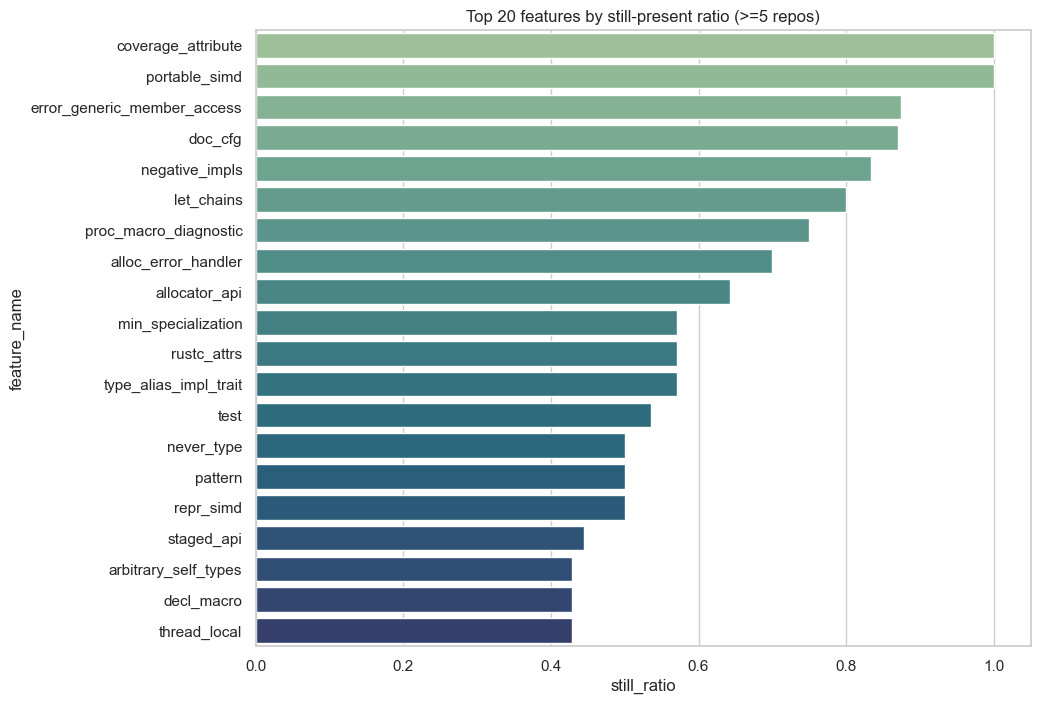

In [57]:
life_df["still_ratio"] = life_df["num_still_present"] / life_df["num_repos"]
top_ratio = life_df[life_df["num_repos"] >= 5].nlargest(20, "still_ratio")

plt.figure(figsize=(10, 8))
sns.barplot(data=top_ratio, x="still_ratio", y="feature_name", palette="crest")
plt.title("Top 20 features by still-present ratio (>=5 repos)")
plt.xlim(0, 1.05)
plt.show()

## 5) Category perspective
- Compare per-category nightly reliance on HEAD vs EVER


/var/folders/p5/wq68nkrn7q78rwt1d8kzlygr0000gn/T/ipykernel_58149/1371848552.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cat_top, x="head_nightly_ratio", y="category", ax=axes[0], palette="rocket")
/var/folders/p5/wq68nkrn7q78rwt1d8kzlygr0000gn/T/ipykernel_58149/1371848552.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cat_top, x="ever_nightly_ratio", y="category", ax=axes[1], palette="mako")


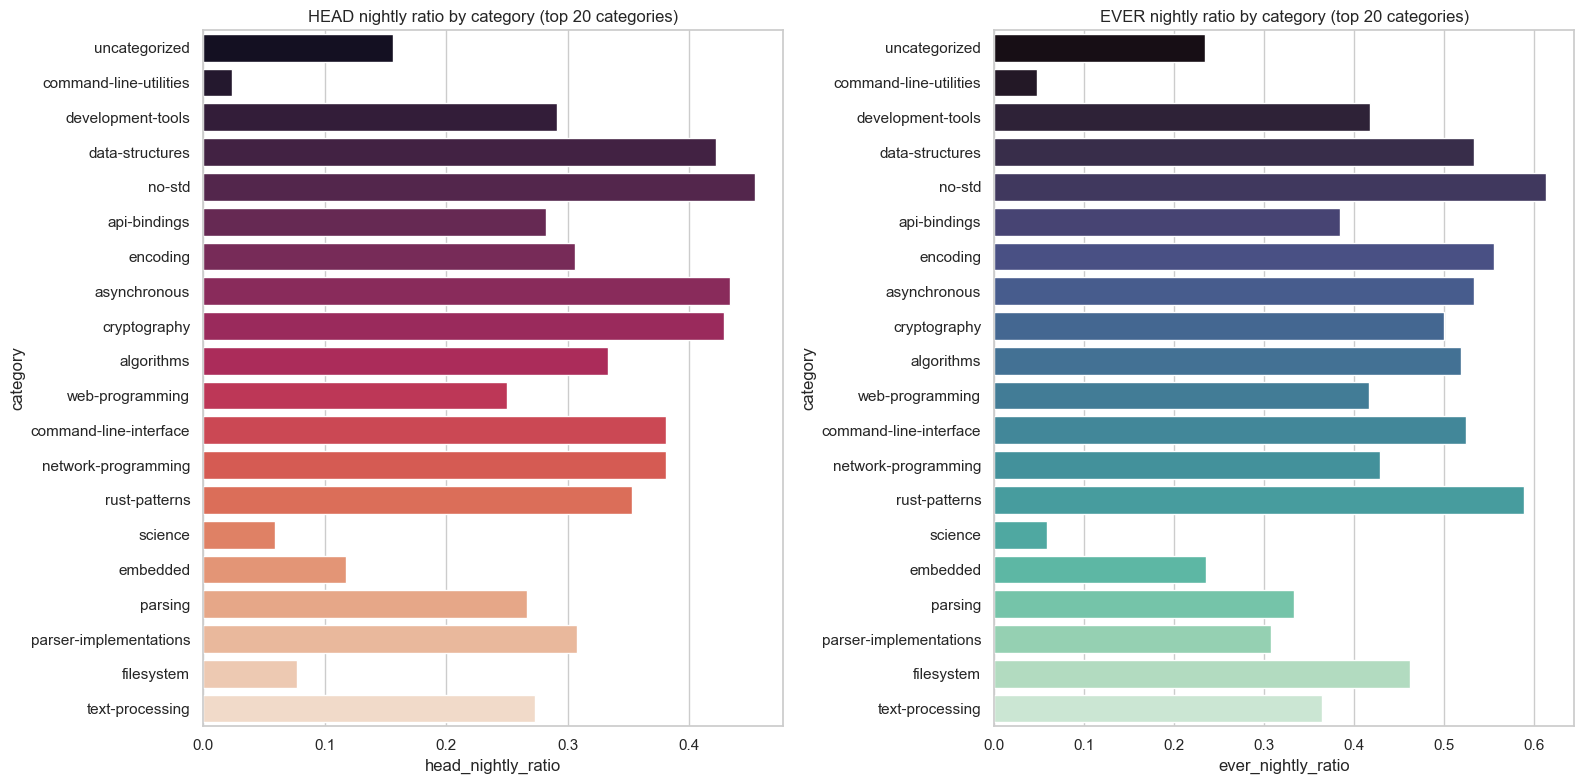

In [58]:
cat_df["head_nightly_ratio"] = pd.to_numeric(cat_df["head_nightly_ratio"], errors="coerce")
cat_df["ever_nightly_ratio"] = pd.to_numeric(cat_df["ever_nightly_ratio"], errors="coerce")
cat_top = cat_df.sort_values("total_repos", ascending=False).head(20)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.barplot(data=cat_top, x="head_nightly_ratio", y="category", ax=axes[0], palette="rocket")
axes[0].set_title("HEAD nightly ratio by category (top 20 categories)")
sns.barplot(data=cat_top, x="ever_nightly_ratio", y="category", ax=axes[1], palette="mako")
axes[1].set_title("EVER nightly ratio by category (top 20 categories)")
plt.tight_layout()
plt.show()

## 6) Next steps (fill in as you iterate)
- Join with a feature→stable_date table to plot adoption curves vs stabilization.
- Compute time-to-stable intervals: (first substantial adoption) → (stable date).
- Segment by core/non-core, popularity bands, downloads/revdeps quantiles.
- Highlight currently unstable gates with high still-present ratios and long lifetimes.

## 7) Stable timeline for selected gates
Hard-code known stable dates (approx; use release notes/unstable book). Dates as ISO-8601; missing → still unstable.

In [59]:
# Known stabilization dates (rough, keep in sync with Rust release notes)
stable_map = {
    "doc_cfg": "1.54.0|2021-07-29",
    "doc_auto_cfg": "1.75.0|2024-01-18",
    "never_type": "1.41.0|2020-01-30",
    "allocator_api": None,   # still unstable
    "specialization": None,  # still unstable
    "plugin": "1.29.0|2018-07-19",  # removed/retired, was unstable
    "test": "1.0.0|2015-05-15",   # public via libtest but feature gate retired
}

def parse_stable_date(s):
    if not s:
        return None
    if "|" in s:
        _, date = s.split("|", 1)
    else:
        date = s
    try:
        return datetime.fromisoformat(date)
    except Exception:
        return None

stable_dates = {k: parse_stable_date(v) for k, v in stable_map.items()}
stable_dates

{'doc_cfg': datetime.datetime(2021, 7, 29, 0, 0),
 'doc_auto_cfg': datetime.datetime(2024, 1, 18, 0, 0),
 'never_type': datetime.datetime(2020, 1, 30, 0, 0),
 'allocator_api': None,
 'specialization': None,
 'plugin': datetime.datetime(2018, 7, 19, 0, 0),
 'test': datetime.datetime(2015, 5, 15, 0, 0)}

## 8) Adoption curves for selected gates
- Pull from `repo_feature_history` in DB.
- Count active repos per quarter (first_seen_date bucket) to see adoption over time.

/var/folders/p5/wq68nkrn7q78rwt1d8kzlygr0000gn/T/ipykernel_58149/2711643946.py:23: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  hist_sel["first_quarter"] = hist_sel["first_seen_date"].dt.to_period("Q")


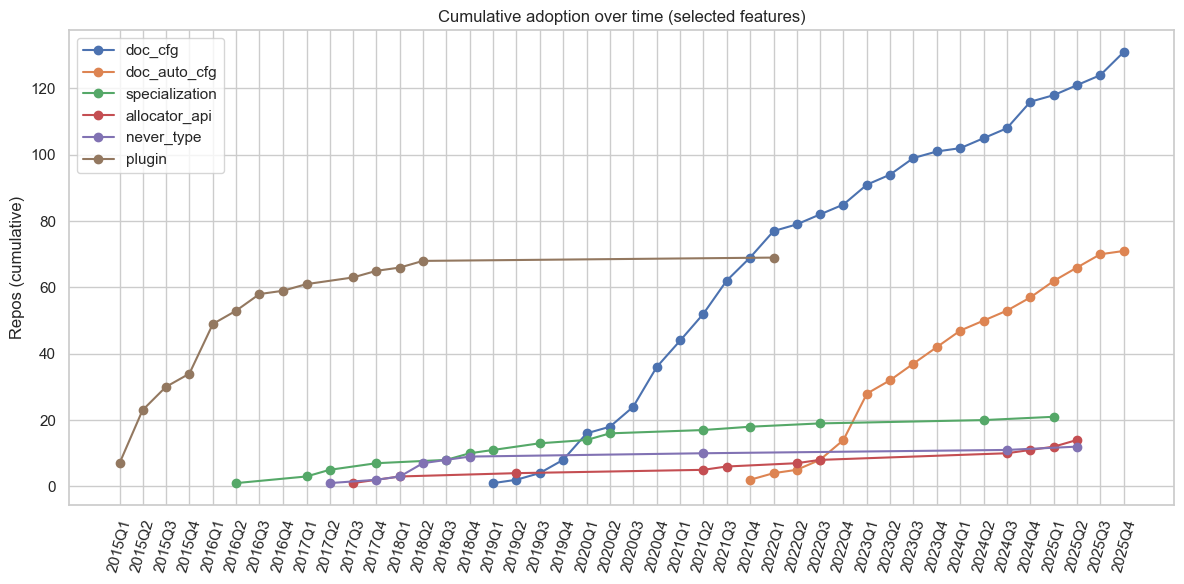

In [60]:
import pandas as pd

def load_history(conn, features):
    qmarks = ",".join(["?"]*len(features))
    df = pd.read_sql_query(
        f"""
        SELECT feature_name, first_seen_date, last_seen_date, still_present, key
        FROM repo_feature_history
        WHERE feature_name IN ({qmarks})
        """,
        conn,
        params=features,
    )
    df["first_seen_date"] = pd.to_datetime(df["first_seen_date"], errors="coerce")
    df["last_seen_date"] = pd.to_datetime(df["last_seen_date"], errors="coerce")
    return df

selected = ["doc_cfg", "doc_auto_cfg", "specialization", "allocator_api", "never_type", "plugin"]

if conn is not None:
    hist_sel = load_history(conn, selected)
    if not hist_sel.empty:
        hist_sel["first_quarter"] = hist_sel["first_seen_date"].dt.to_period("Q")
        adoption = (hist_sel.groupby(["feature_name", "first_quarter"])  # count repos first adopting per quarter
                             .size()
                             .reset_index(name="count"))
        adoption = adoption.sort_values("first_quarter")
        all_quarters = adoption["first_quarter"].dropna().sort_values().unique()
        plt.figure(figsize=(12,6))
        for feat in selected:
            sub = adoption[adoption["feature_name"] == feat]
            if sub.empty:
                continue
            # cumulative adoption over time
            sub = sub.sort_values("first_quarter")
            sub["cum"] = sub["count"].cumsum()
            x = sub["first_quarter"].dt.to_timestamp()
            plt.plot(x, sub["cum"], marker="o", label=feat)
        if len(all_quarters) > 0:
            xticks = pd.PeriodIndex(all_quarters).to_timestamp()
            plt.gca().set_xticks(xticks)
            plt.gca().set_xticklabels([str(q) for q in all_quarters], rotation=75)
        plt.title("Cumulative adoption over time (selected features)")
        plt.ylabel("Repos (cumulative)")
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("No history rows for selected features.")
else:
    print("DB not available; skip adoption curves.")

## 9) Time-to-stable vs adoption threshold
- For stable gates: pick threshold (e.g., first quarter when cumulative >= 5/20 repos)
- Compute days from that threshold to stable date.

In [61]:
def threshold_date(adoption_df, feat, threshold):
    sub = adoption_df[adoption_df["feature_name"] == feat].sort_values("first_quarter")
    if sub.empty:
        return None
    sub = sub.copy()
    sub["cum"] = sub["count"].cumsum()
    hit = sub[sub["cum"] >= threshold]
    if hit.empty:
        return None
    q = hit.iloc[0]["first_quarter"]
    # approximate to quarter start
    return q.to_timestamp()

if conn is not None and 'hist_sel' in locals() and not hist_sel.empty:
    thresholds = [5, 20]
    results = []
    adoption = (hist_sel.groupby(["feature_name", "first_quarter"]).size().reset_index(name="count"))
    for feat in selected:
        stab = stable_dates.get(feat)
        for th in thresholds:
            tdate = threshold_date(adoption, feat, th)
            delta_days = None
            if tdate is not None and stab is not None:
                delta_days = (stab - tdate).days
            results.append({"feature": feat, "threshold": th, "threshold_date": tdate, "stable_date": stab, "days_to_stable": delta_days})
    res_df = pd.DataFrame(results)
    display(res_df)
else:
    print("Skip time-to-stable; missing data.")

,feature,threshold,threshold_date,stable_date,days_to_stable
0,doc_cfg,5,2019-10-01,2021-07-29,667.0
1,doc_cfg,20,2020-07-01,2021-07-29,393.0
2,doc_auto_cfg,5,2022-04-01,2024-01-18,657.0
3,doc_auto_cfg,20,2023-01-01,2024-01-18,382.0
4,specialization,5,2017-04-01,NaT,NaN
5,specialization,20,2024-04-01,NaT,NaN
6,allocator_api,5,2021-04-01,NaT,NaN
7,allocator_api,20,NaT,NaT,NaN
8,never_type,5,2018-04-01,2020-01-30,669.0
9,never_type,20,NaT,2020-01-30,NaN


## 10) Core vs non-core, categories, and size signals
- Join `repos` with history to see where adoption comes from.
- Compare adoption counts by core/non-core and top_category.

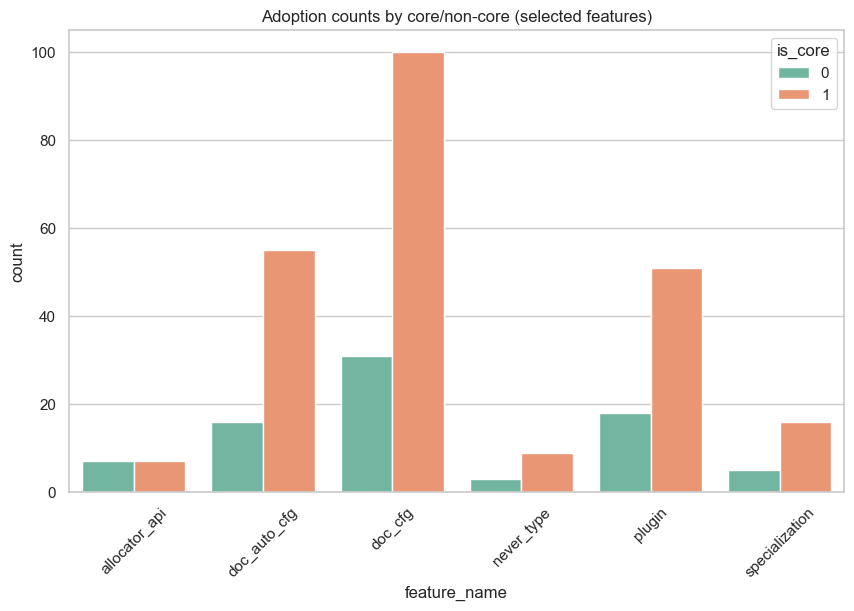

/var/folders/p5/wq68nkrn7q78rwt1d8kzlygr0000gn/T/ipykernel_58149/631073858.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_cat, x="count", y="top_category", palette="Blues_r")


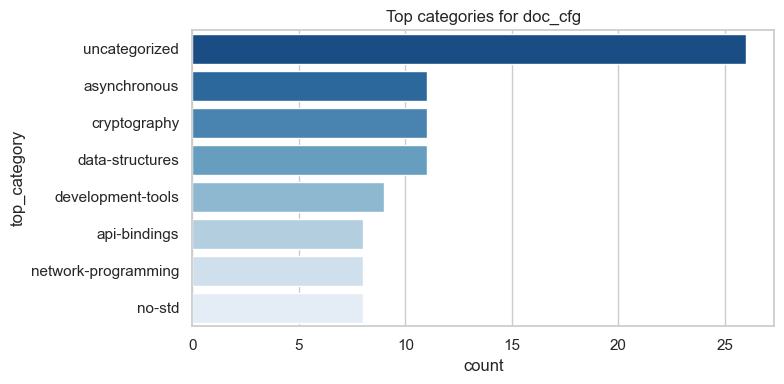

/var/folders/p5/wq68nkrn7q78rwt1d8kzlygr0000gn/T/ipykernel_58149/631073858.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_cat, x="count", y="top_category", palette="Blues_r")


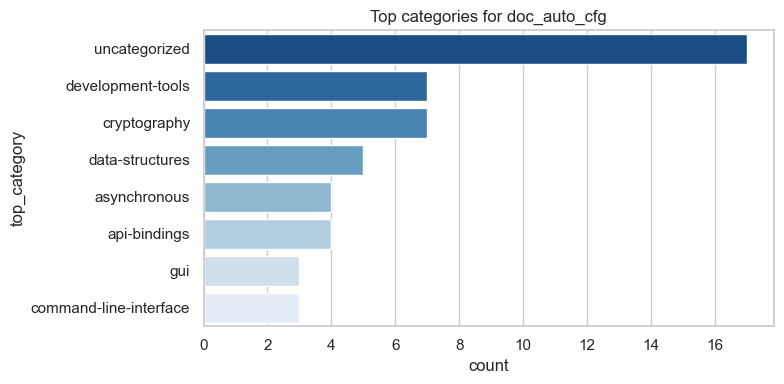

/var/folders/p5/wq68nkrn7q78rwt1d8kzlygr0000gn/T/ipykernel_58149/631073858.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_cat, x="count", y="top_category", palette="Blues_r")


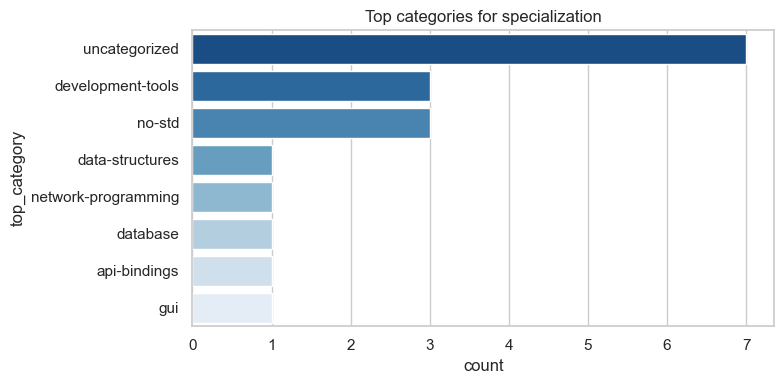

/var/folders/p5/wq68nkrn7q78rwt1d8kzlygr0000gn/T/ipykernel_58149/631073858.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_cat, x="count", y="top_category", palette="Blues_r")


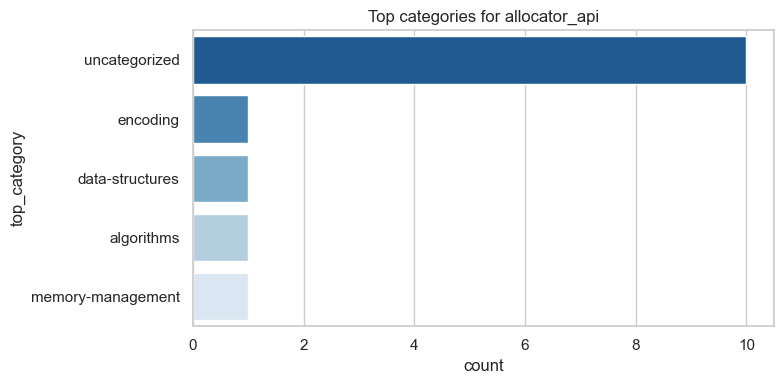

/var/folders/p5/wq68nkrn7q78rwt1d8kzlygr0000gn/T/ipykernel_58149/631073858.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_cat, x="count", y="top_category", palette="Blues_r")


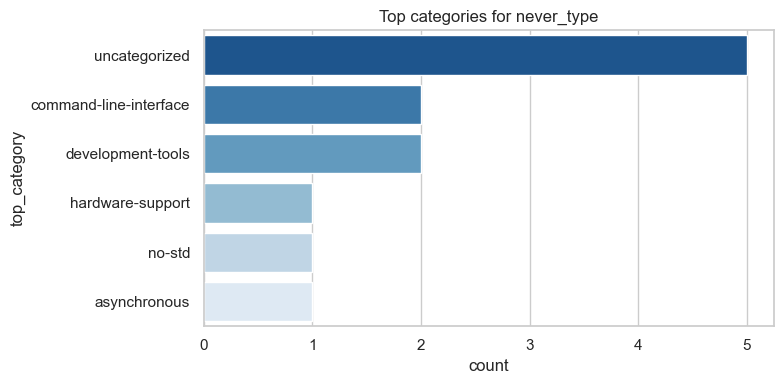

/var/folders/p5/wq68nkrn7q78rwt1d8kzlygr0000gn/T/ipykernel_58149/631073858.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_cat, x="count", y="top_category", palette="Blues_r")


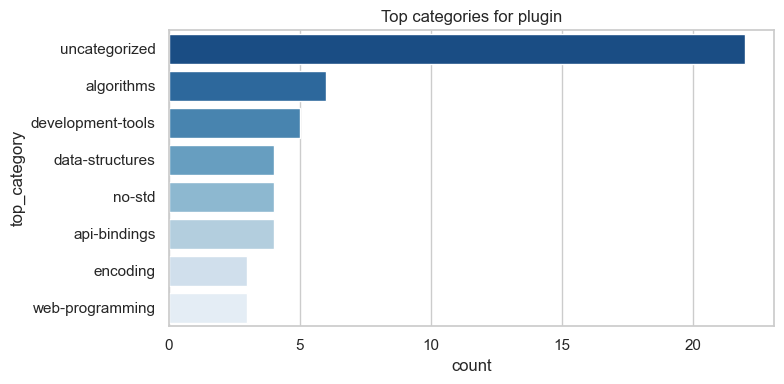

In [62]:
def load_repos(conn):
    r = pd.read_sql_query("SELECT key, is_core, top_categories, downloads_sum, revdeps_sum FROM repos", conn)
    r["is_core"] = r["is_core"].fillna(0).astype(int)
    return r

if conn is not None:
    repos_df = load_repos(conn)
    hist_sel = load_history(conn, selected)
    if not hist_sel.empty:
        merged = hist_sel.merge(repos_df, on="key", how="left")
        merged["top_cat_primary"] = merged["top_categories"].fillna("").apply(lambda s: s.split(",")[0] if s else "uncategorized")
        # core vs non-core counts per feature
        core_counts = merged.groupby(["feature_name", "is_core"]).size().reset_index(name="count")
        plt.figure(figsize=(10,6))
        sns.barplot(data=core_counts, x="feature_name", y="count", hue="is_core", palette="Set2")
        plt.title("Adoption counts by core/non-core (selected features)")
        plt.xticks(rotation=45)
        plt.show()

        # category view (top 8 per feature)
        for feat in selected:
            sub = merged[merged["feature_name"] == feat]
            top_cat = sub["top_cat_primary"].value_counts().head(8).reset_index()
            top_cat.columns = ["top_category", "count"]
            plt.figure(figsize=(8,4))
            sns.barplot(data=top_cat, x="count", y="top_category", palette="Blues_r")
            plt.title(f"Top categories for {feat}")
            plt.tight_layout()
            plt.show()
    else:
        print("No history data for selected features.")
else:
    print("DB not available; skip core/category analysis.")

## 11) Pressure indicators for unstable gates
- For unstable gates (no stable date): look at adoption level, growth, and retention.
- Use current `still_present` counts and cumulative adoption.

In [63]:
import pandas as pd
import numpy as np
import sqlite3
from pathlib import Path

# --- 路径配置 ---
TIMELINE_CSV = Path("feature_timeline.csv") 
DB_PATH = Path("features_head_v3.db")

def prepare_impact_data(conn, timeline_path):
    # 1. 加载 Feature 生命周期时间表
    if not timeline_path.exists():
        print(f"Error: {timeline_path} not found. Please check file location.")
        return None, None
    
    # 读取 CSV
    timeline = pd.read_csv(timeline_path)
    
    # 标准化列名
    if "feature" in timeline.columns:
        timeline.rename(columns={"feature": "feature_name"}, inplace=True)
    
    # 检查关键列
    if "feature_name" not in timeline.columns or "stabilized_date" not in timeline.columns:
        print("Error: CSV missing 'feature' or 'stabilized_date' columns.")
        return None, None

    # --- 【关键修复】统一日期格式 ---
    # 1. utc=True: 强制解析为 UTC (处理混合格式)
    # 2. .dt.tz_localize(None): 移除时区信息，变为 naive datetime，避免相减报错
    timeline["stabilized_date"] = pd.to_datetime(timeline["stabilized_date"], errors="coerce", utc=True).dt.tz_localize(None)
    
    # 只保留有转正日期的
    stable_features = timeline.dropna(subset=["stabilized_date"]).copy()
    
    print(f"Loaded timeline: {len(timeline)} rows. Valid stabilized features: {len(stable_features)}")

    # 2. 从 DB 加载使用记录
    target_feats = stable_features["feature_name"].unique().tolist()
    
    if not target_feats:
        print("No stabilized features found.")
        return None, None

    placeholders = ",".join(["?"] * len(target_feats))
    query = f"""
        SELECT h.feature_name, h.key as repo_key, h.first_seen_date, r.is_core
        FROM repo_feature_history h
        LEFT JOIN repos r ON h.key = r.key
        WHERE h.feature_name IN ({placeholders})
    """
    
    print("Querying database for history...")
    history = pd.read_sql_query(query, conn, params=target_feats)
    
    # --- 【关键修复】统一日期格式 ---
    # 同样处理 history 中的日期，确保与 timeline 格式一致
    history["first_seen_date"] = pd.to_datetime(history["first_seen_date"], errors="coerce", utc=True).dt.tz_localize(None)
    
    if history.empty:
        print("No history data found.")
        return None, None

    # 3. 合并数据并计算相对时间
    merged = history.merge(stable_features[["feature_name", "stabilized_date"]], on="feature_name", how="inner")
    
    # 现在两者都是 naive datetime，可以直接相减
    merged["days_relative"] = (merged["first_seen_date"] - merged["stabilized_date"]).dt.days
    
    # 标记分类
    merged["adoption_type"] = np.where(merged["days_relative"] < 0, "Early Adopter (Unstable)", "Stable Adopter")
    
    # 4. 计算指标
    impact_summary = merged.groupby("feature_name").agg(
        stabilized_date=("stabilized_date", "first"),
        total_repos=("repo_key", "nunique"),
        pre_stable_count=("adoption_type", lambda x: (x == "Early Adopter (Unstable)").sum()),
        post_stable_count=("adoption_type", lambda x: (x == "Stable Adopter").sum())
    ).reset_index()
    
    impact_summary["pre_stable_ratio"] = impact_summary["pre_stable_count"] / impact_summary["total_repos"]
    
    return merged, impact_summary

# 执行处理
impact_df = None
summary_df = None

if conn is not None:
    impact_df, summary_df = prepare_impact_data(conn, TIMELINE_CSV)
    
    if summary_df is not None:
        print("\n--- Top 5 Features by Total Adoption (Stabilized Only) ---")
        display(summary_df.sort_values("total_repos", ascending=False).head(5))
        
        print("\n--- Top 5 'De-facto Standard' Features (High Pre-stable Usage) ---")
        popular_unstable = summary_df[summary_df["total_repos"] > 10]
        if not popular_unstable.empty:
            display(popular_unstable.sort_values("pre_stable_ratio", ascending=False).head(5))
    else:
        print("Could not generate summary.")
else:
    print("DB connection missing.")

Loaded timeline: 536 rows. Valid stabilized features: 204
Querying database for history...

--- Top 5 Features by Total Adoption (Stabilized Only) ---


,feature_name,stabilized_date,total_repos,pre_stable_count,post_stable_count,pre_stable_ratio
50,macro_rules,2015-05-15,41,41,0,1.000000
60,proc_macro,2017-02-02,29,7,22,0.241379
7,associated_types,2015-05-15,24,24,0,1.000000
67,slicing_syntax,2015-05-15,21,21,0,1.000000
8,async_await,2019-11-07,20,18,2,0.900000



--- Top 5 'De-facto Standard' Features (High Pre-stable Usage) ---


,feature_name,stabilized_date,total_repos,pre_stable_count,post_stable_count,pre_stable_ratio
7,associated_types,2015-05-15,24,24,0,1.0
25,default_type_params,2015-05-15,19,19,0,1.0
41,globs,2015-05-15,19,19,0,1.0
50,macro_rules,2015-05-15,41,41,0,1.0
67,slicing_syntax,2015-05-15,21,21,0,1.0


## 12) Build wide tables (repo×feature and feature-level)

Wide A: repo × feature with repo attributes, feature timeline, pre/post-stable flags.
Wide B: feature-level aggregation with adoption signals and timelines.


Plotting top 8 stabilized features...


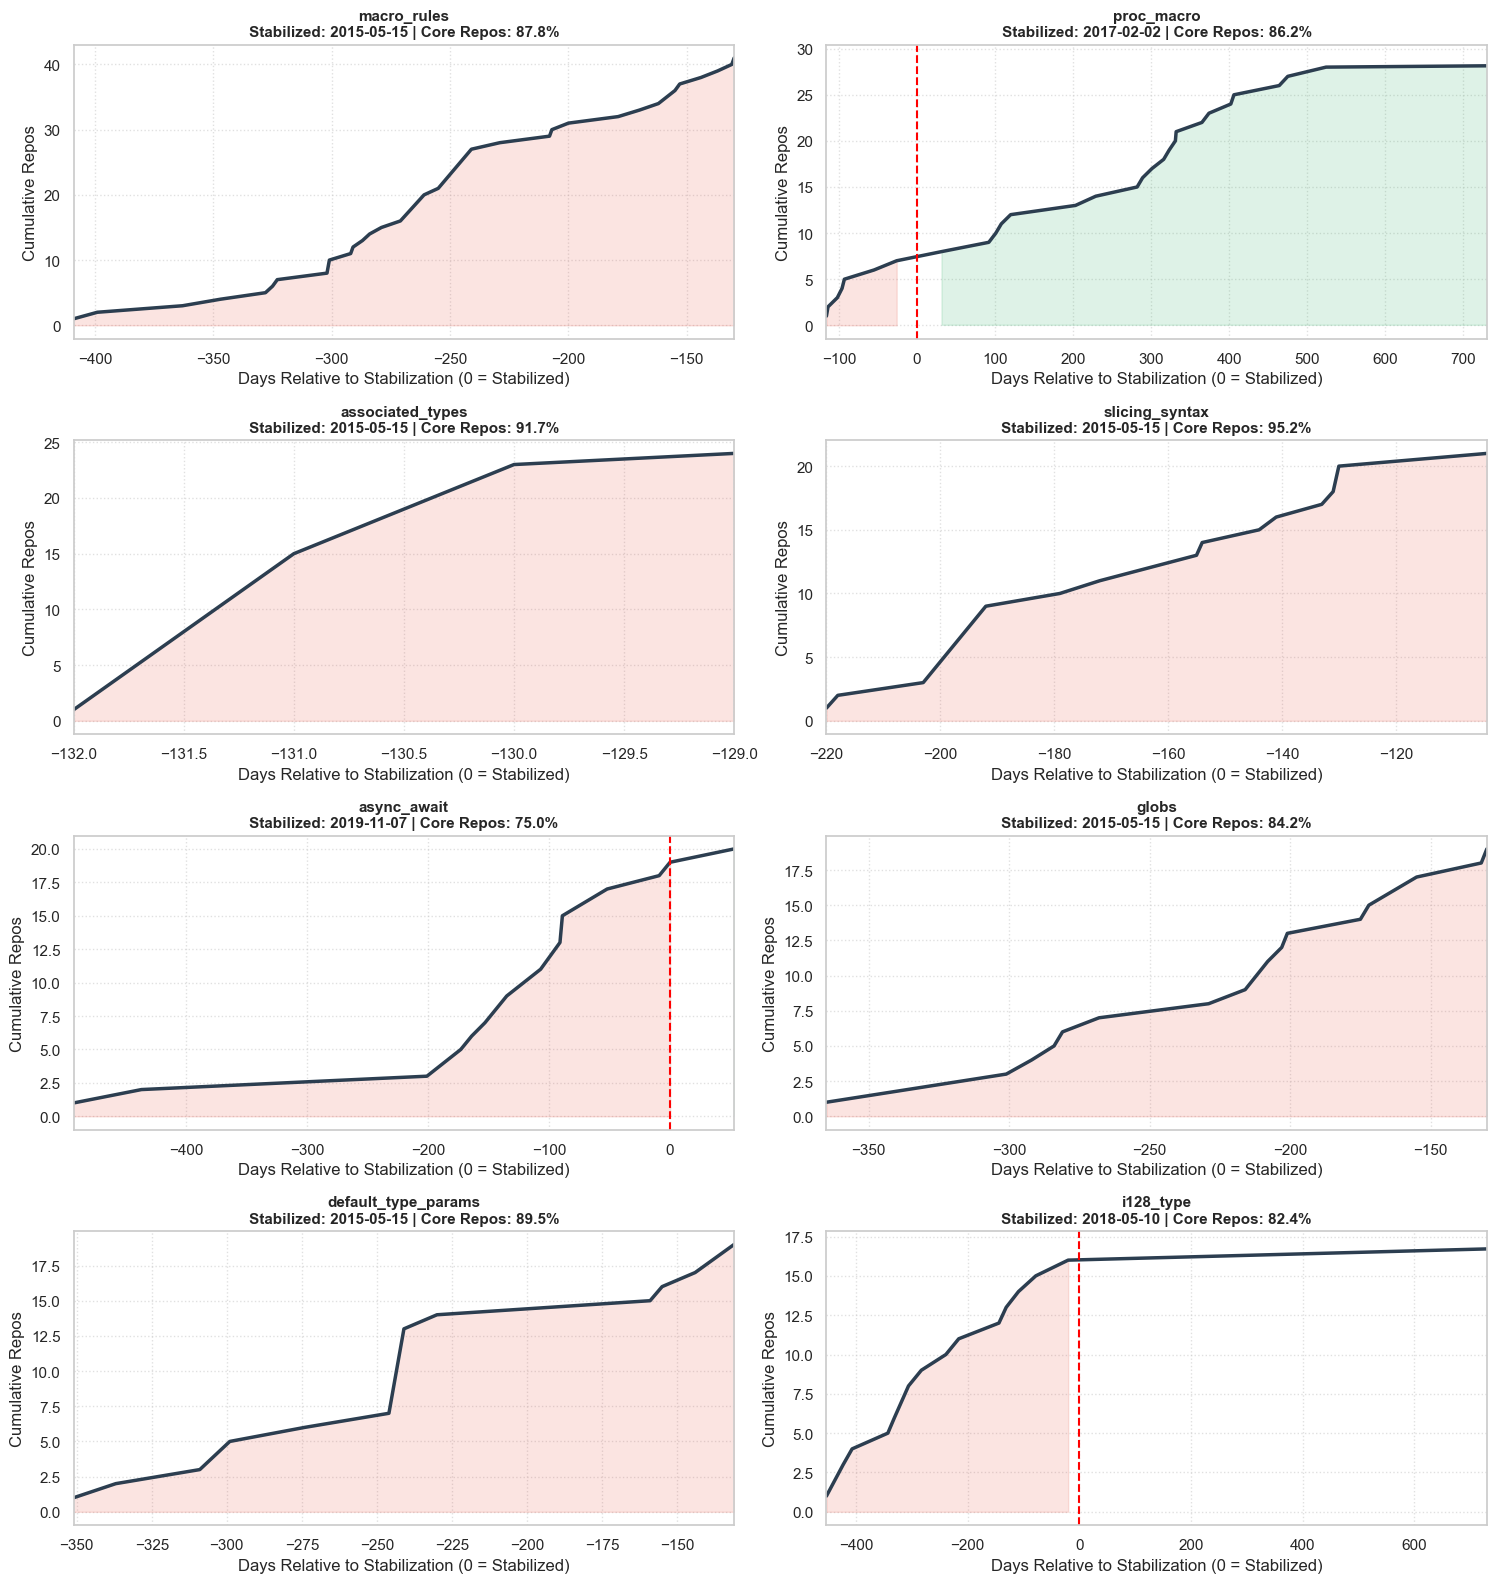

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

def plot_stabilization_impact(impact_df, summary_df, top_n=8):
    """
    绘制以转正日(T=0)为中心的累计采用曲线。
    可视化将直观展示：转正(T=0)是否是使用量爆发的拐点。
    """
    if impact_df is None or impact_df.empty:
        print("No data available for plotting.")
        return

    # 选取总使用量最大的 Top N 特性
    # 排除掉那些 stabilized_date 明显有问题的（比如全部堆积在 2020-01-30 的老特性）
    # 但为了让你看到所有结果，这里先不做硬性过滤，只在图标题提醒
    top_features = summary_df.sort_values("total_repos", ascending=False).head(top_n)["feature_name"].tolist()
    
    if not top_features:
        print("No features to plot.")
        return

    # 动态计算子图行列数
    n_plots = len(top_features)
    cols = 2
    rows = (n_plots + 1) // 2
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
    if rows == 1 and cols == 1:
        axes = [axes] # 只有一个图时包装成列表
    else:
        axes = axes.flatten()
    
    print(f"Plotting top {n_plots} stabilized features...")
    
    for i, feat in enumerate(top_features):
        ax = axes[i]
        subset = impact_df[impact_df["feature_name"] == feat].copy()
        
        # 按相对天数排序
        subset = subset.sort_values("days_relative")
        
        # 聚合每一天的新增用户数，计算累计
        daily_counts = subset.groupby("days_relative").size().reset_index(name="new_users")
        daily_counts["cumulative_users"] = daily_counts["new_users"].cumsum()
        
        # 获取该特性的转正日期
        stable_date_obj = subset["stabilized_date"].iloc[0]
        stable_date_str = stable_date_obj.strftime("%Y-%m-%d")
        
        # --- 核心绘图 ---
        # 1. 绘制累计曲线
        sns.lineplot(data=daily_counts, x="days_relative", y="cumulative_users", ax=ax, linewidth=2.5, color="#2c3e50")
        
        # 2. 填充 Pre-stable 区域 (红色 - 转正前)
        pre_data = daily_counts[daily_counts["days_relative"] <= 0]
        if not pre_data.empty:
            ax.fill_between(pre_data["days_relative"], 0, pre_data["cumulative_users"], color="#e74c3c", alpha=0.15, label="Pre-stable")
            
        # 3. 填充 Post-stable 区域 (绿色 - 转正后)
        post_data = daily_counts[daily_counts["days_relative"] > 0]
        if not post_data.empty:
            ax.fill_between(post_data["days_relative"], 0, post_data["cumulative_users"], color="#27ae60", alpha=0.15, label="Post-stable")
        
        # 4. T=0 参考线
        ax.axvline(0, color="red", linestyle="--", linewidth=1.5)
        
        # 标题和标签
        # 计算核心库使用占比
        core_ratio = subset[subset["is_core"] == 1].shape[0] / len(subset) if len(subset) > 0 else 0
        
        # 检查是否为可疑日期 (2020-01-30)
        date_warning = " (⚠️Date Suspect)" if stable_date_str == "2020-01-30" else ""
        
        ax.set_title(f"{feat}\nStabilized: {stable_date_str}{date_warning} | Core Repos: {core_ratio:.1%}", fontsize=11, fontweight='bold')
        ax.set_xlabel("Days Relative to Stabilization (0 = Stabilized)")
        ax.set_ylabel("Cumulative Repos")
        ax.grid(True, linestyle=":", alpha=0.6)
        
        # 设置 X 轴范围，聚焦在转正前后 2 年 (730天)
        # 这样可以看清楚 T=0 附近的斜率变化
        min_day = max(daily_counts["days_relative"].min(), -730) 
        max_day = min(daily_counts["days_relative"].max(), 730)
        if max_day > min_day:
            ax.set_xlim(min_day, max_day)

    # 隐藏多余的空白子图
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
        
    plt.tight_layout()
    plt.show()

# 执行绘图逻辑
if 'impact_df' in locals() and impact_df is not None and 'summary_df' in locals():
    plot_stabilization_impact(impact_df, summary_df, top_n=8)
else:
    print("Please run the previous cell (Data Preparation) first to generate impact_df.")

--- Loading Timeline for Duration Calculation ---
Analyzing 5 stabilized features...


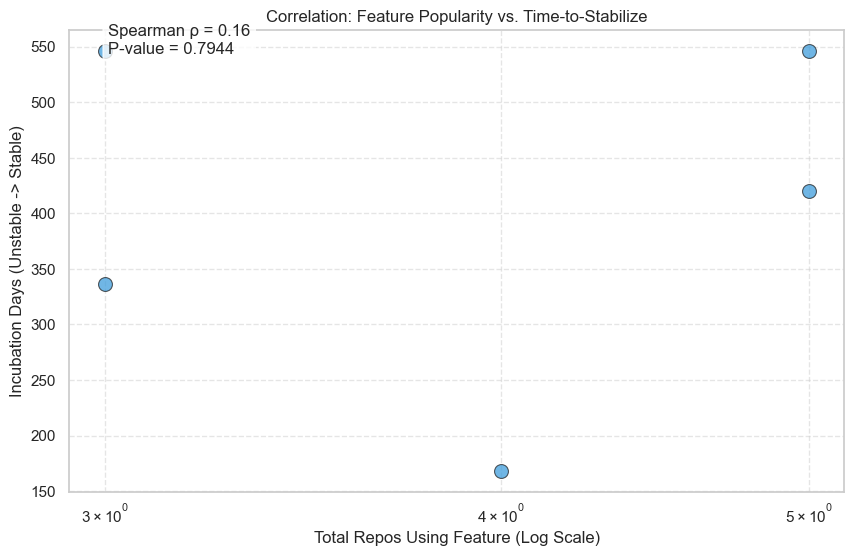


=== Analysis Conclusion ===
❌ 无显著相关性 (Not Statistically Significant).
结论：特性的转正速度似乎与使用它的人数多少没有明显的单调关系。


/var/folders/p5/wq68nkrn7q78rwt1d8kzlygr0000gn/T/ipykernel_58149/3818493100.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=analysis_df, x="Category", y="incubation_days", palette="Set2")


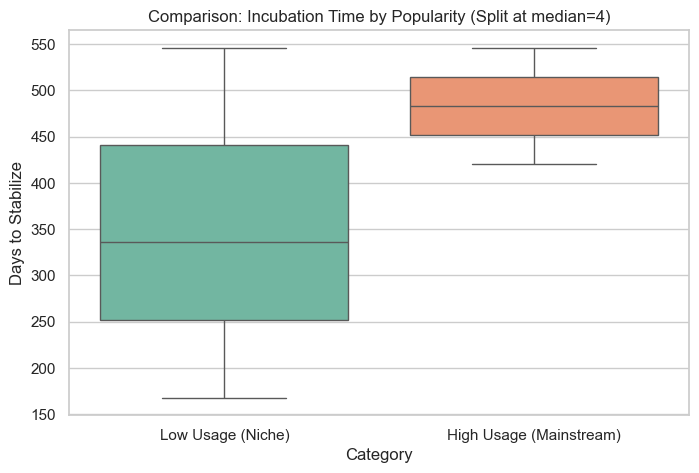

In [65]:
# %%
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_usage_vs_speed(summary_df, timeline_path):
    """
    分析：使用量（热度）是否影响转正速度（孵化期时长）？

    注意：
    - 使用 Spearman 相关系数（基于 rank 的单调关系），更稳健；
    - 仍然在 log10(total_repos) 上做线性回归，只作为“趋势线可视化”，不再拿来当相关系数。
    """
    print("--- Loading Timeline for Duration Calculation ---")
    timeline = pd.read_csv(timeline_path)
    if "feature" in timeline.columns:
        timeline.rename(columns={"feature": "feature_name"}, inplace=True)
    
    # 清洗日期
    for col in ["first_unstable_date", "stabilized_date"]:
        timeline[col] = pd.to_datetime(timeline[col], errors="coerce", utc=True).dt.tz_localize(None)
    
    # 1. 计算孵化期 (Incubation Duration)
    finished = timeline.dropna(subset=["first_unstable_date", "stabilized_date"]).copy()
    finished["incubation_days"] = (finished["stabilized_date"] - finished["first_unstable_date"]).dt.days
    finished = finished[finished["incubation_days"] > 0].copy()
    
    # 2. 关联使用量数据 (Usage Volume)
    analysis_df = finished.merge(
        summary_df[["feature_name", "pre_stable_count", "total_repos"]],
        on="feature_name",
        how="inner",
    )
    
    # 3. 过滤掉极低频使用的特性 (噪音)
    analysis_df = analysis_df[analysis_df["total_repos"] >= 3]
    
    if analysis_df.empty:
        print("数据不足，无法分析。")
        return

    print(f"Analyzing {len(analysis_df)} stabilized features...")

    # --- 可视化 1: 散点图 ---
    plt.figure(figsize=(10, 6))
    
    x_data = analysis_df["total_repos"]
    y_data = analysis_df["incubation_days"]
    
    sns.scatterplot(
        data=analysis_df,
        x="total_repos",
        y="incubation_days",
        s=100,
        alpha=0.7,
        edgecolor="k",
        color="#3498db",
    )
    
    plt.xscale("log")
    plt.title("Correlation: Feature Popularity vs. Time-to-Stabilize")
    plt.xlabel("Total Repos Using Feature (Log Scale)")
    plt.ylabel("Incubation Days (Unstable -> Stable)")
    
    # --- Spearman 相关系数 ---
    if len(analysis_df) > 2:
        rho, p_value = stats.spearmanr(x_data, y_data)
        label_text = f"Spearman ρ = {rho:.2f}\nP-value = {p_value:.4f}"
    else:
        rho, p_value = np.nan, np.nan
        label_text = "Not enough data for correlation"
    
    plt.text(
        0.05,
        0.95,
        label_text,
        transform=plt.gca().transAxes,
        fontsize=12,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
    )
    
    plt.grid(True, which="both", linestyle="--", alpha=0.5)
    plt.show()
    
    # --- 结论文本（基于 Spearman） ---
    print("\n=== Analysis Conclusion ===")
    if len(analysis_df) <= 2 or np.isnan(rho):
        print("数据点过少，无法得出显著性结论。")
    elif p_value > 0.05:
        print("❌ 无显著相关性 (Not Statistically Significant).")
        print("结论：特性的转正速度似乎与使用它的人数多少没有明显的单调关系。")
    elif rho < 0:
        print("✅ 负相关 (Negative Correlation): 越热门，转正越快！")
        print("结论：'加速假设'得到一定支持。社区的高频使用和反馈似乎与更短的孵化期相关。")
    else:
        print("⚠️ 正相关 (Positive Correlation): 越热门，转正越慢！")
        print("结论：'谨慎假设'得到一定支持。广泛使用的特性可能涉及更多边界情况和兼容性风险，导致官方需要更长时间来打磨。")

    # --- 可视化 2: 分组箱线图 (按热度分层) ---
    median_usage = analysis_df["total_repos"].median()
    analysis_df["Category"] = np.where(
        analysis_df["total_repos"] > median_usage,
        "High Usage (Mainstream)",
        "Low Usage (Niche)",
    )
    
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=analysis_df, x="Category", y="incubation_days", palette="Set2")
    plt.title(f"Comparison: Incubation Time by Popularity (Split at median={int(median_usage)})")
    plt.ylabel("Days to Stabilize")
    plt.show()

# 执行分析：注意这里仍然传 summary_df
if 'summary_df' in locals() and summary_df is not None:
    analyze_usage_vs_speed(summary_df, TIMELINE_CSV)
else:
    print("Please run the Data Prep cell first to generate summary_df.")


--- 正在加载最终版数据 (Deep Scan Version) ---
Using 'incubation_days_calculated' from Deep Scan.
全量特性: 80
用于【速度分析】的有效演进样本 (N): 17


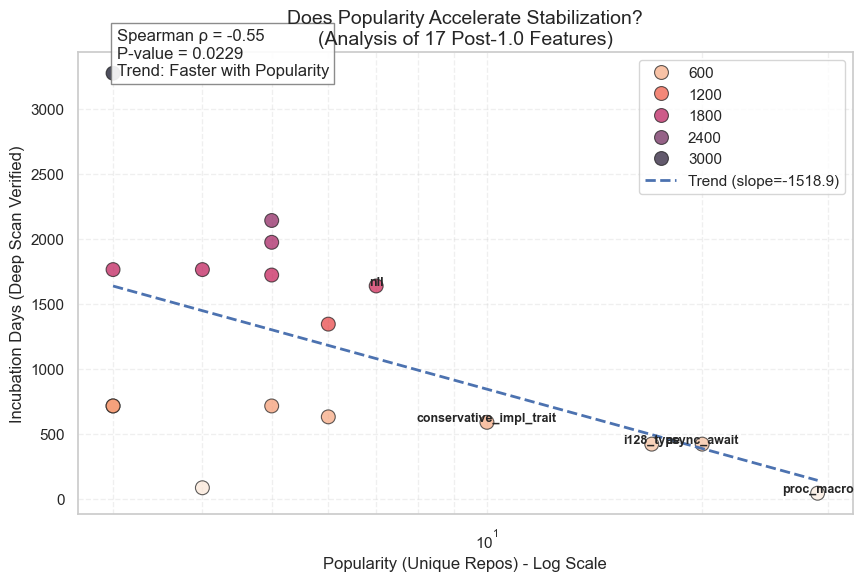

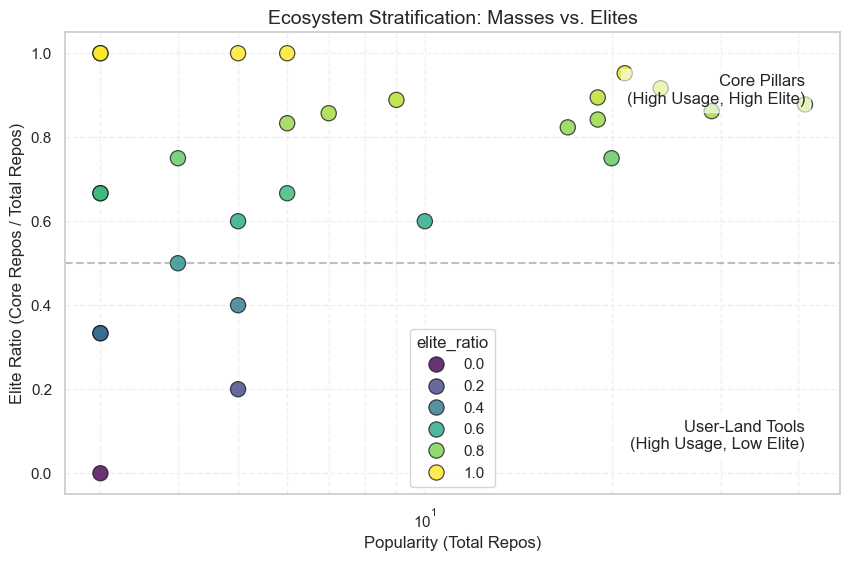

In [66]:
# %%
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

def analyze_final_conclusions(impact_df, timeline_path):
    print("--- 正在加载最终版数据 (Deep Scan Version) ---")
    
    # 1. 加载并清洗 Timeline
    timeline = pd.read_csv(timeline_path)
    if "feature" in timeline.columns:
        timeline.rename(columns={"feature": "feature_name"}, inplace=True)
        
    # 优先使用 Deep Scan 的 incubation_days_calculated
    if "incubation_days_calculated" in timeline.columns:
        timeline["incubation_days"] = timeline["incubation_days_calculated"]
        print("Using 'incubation_days_calculated' from Deep Scan.")
    else:
        print("Using fallback calculation for incubation_days.")
        for col in ["first_unstable_date", "stabilized_date"]:
            timeline[col] = pd.to_datetime(
                timeline[col],
                errors="coerce",
                utc=True,
            ).dt.tz_localize(None)
        timeline["incubation_days"] = (
            timeline["stabilized_date"] - timeline["first_unstable_date"]
        ).dt.days

    # 2. 准备使用量数据
    if impact_df is None or impact_df.empty:
        print("❌ Error: impact_df is missing.")
        return

    usage_stats = impact_df.groupby("feature_name").agg(
        total_repos=("repo_key", "nunique"),
        core_repos=("repo_key", lambda x: impact_df.loc[x.index, "is_core"].sum()),
    ).reset_index()
    
    # 精英浓度
    usage_stats["elite_ratio"] = usage_stats["core_repos"] / usage_stats["total_repos"]
    
    # 合并时间线 + 使用量
    full_df = timeline.merge(usage_stats, on="feature_name", how="inner")
    
    # 3. 过滤出“演进特性”用于速度分析
    evolution_df = full_df[
        (full_df["stabilized_version"] != "1.0.0")
        & (full_df["incubation_days"] > 0)
        & (full_df["total_repos"] >= 3)
    ].copy()
    
    print(f"全量特性: {len(full_df)}")
    print(f"用于【速度分析】的有效演进样本 (N): {len(evolution_df)}")
    
    # ===================================================
    # 图表 1: 演进速度分析 (Patience Plot)
    # ===================================================
    plt.figure(figsize=(10, 6))
    
    sns.scatterplot(
        data=evolution_df,
        x="total_repos",
        y="incubation_days",
        s=100,
        alpha=0.7,
        hue="incubation_days",   # 保留颜色表示孵化期长短
        palette="rocket_r",
        edgecolor="k",
    )
    
    plt.xscale("log")
    plt.title(
        f"Does Popularity Accelerate Stabilization?\n"
        f"(Analysis of {len(evolution_df)} Post-1.0 Features)",
        fontsize=14,
    )
    plt.xlabel("Popularity (Unique Repos) - Log Scale", fontsize=12)
    plt.ylabel("Incubation Days (Deep Scan Verified)", fontsize=12)
    
    # --- 线性回归（用于画趋势线） + Spearman 相关（用于解释） ---
    if len(evolution_df) > 5:
        x_log = np.log10(evolution_df["total_repos"])
        y = evolution_df["incubation_days"]
        
        # 线性回归只用于画线，不用它的 r 当相关系数
        slope, intercept, r_lin, p_lin, err = stats.linregress(x_log, y)
        x_vals = np.linspace(x_log.min(), x_log.max(), 100)
        plt.plot(
            10**x_vals,
            slope * x_vals + intercept,
            "b--",
            linewidth=2,
            label=f"Trend (slope={slope:.1f})",
        )
        
        # Spearman 相关系数（真正用于解释“单调关系”）
        rho, p_spear = stats.spearmanr(evolution_df["total_repos"], y)
        
        if p_spear < 0.05:
            conclusion = "Faster" if rho < 0 else "Slower"
        else:
            conclusion = "Neutral"
        
        stats_text = (
            f"Spearman ρ = {rho:.2f}\n"
            f"P-value = {p_spear:.4f}\n"
            f"Trend: {conclusion} with Popularity"
        )
        
        plt.text(
            0.05,
            0.95,
            stats_text,
            transform=plt.gca().transAxes,
            bbox=dict(facecolor="white", alpha=0.9, edgecolor="gray"),
        )
    
    # 标注最热门的几个特性名称
    for _, row in evolution_df.nlargest(5, "total_repos").iterrows():
        plt.text(
            row["total_repos"],
            row["incubation_days"] + 10,
            row["feature_name"],
            fontsize=9,
            fontweight="bold",
            ha="center",
        )

    plt.grid(True, which="both", linestyle="--", alpha=0.3)
    plt.legend()
    plt.show()

    # ===================================================
    # 图表 2: 生态分层矩阵 (Class Plot)
    # ===================================================
    strat_df = full_df[full_df["total_repos"] >= 3].copy()
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=strat_df,
        x="total_repos",
        y="elite_ratio",
        s=120,
        alpha=0.8,
        hue="elite_ratio",
        palette="viridis",
        edgecolor="k",
    )
    
    plt.xscale("log")
    plt.title("Ecosystem Stratification: Masses vs. Elites", fontsize=14)
    plt.xlabel("Popularity (Total Repos)", fontsize=12)
    plt.ylabel("Elite Ratio (Core Repos / Total Repos)", fontsize=12)
    plt.axhline(0.5, color="gray", linestyle="--", alpha=0.5)
    
    plt.text(
        strat_df["total_repos"].max(),
        0.95,
        "Core Pillars\n(High Usage, High Elite)",
        ha="right",
        va="top",
        bbox=dict(facecolor="white", alpha=0.6),
    )
    plt.text(
        strat_df["total_repos"].max(),
        0.05,
        "User-Land Tools\n(High Usage, Low Elite)",
        ha="right",
        va="bottom",
        bbox=dict(facecolor="white", alpha=0.6),
    )
    
    plt.grid(True, which="both", linestyle="--", alpha=0.3)
    plt.show()

# 运行最终分析
# 确保传入的是 deep scan 生成的 feature timeline CSV
if 'impact_df' in locals() and impact_df is not None:
    analyze_final_conclusions(impact_df, "feature_timeline_deep.csv")
else:
    print("Please run Cell 11 first.")


In [ ]:
# %%
import pandas as pd
from pathlib import Path
import numpy as np

TIMELINE_DEEP = Path("feature_timeline_deep.csv")

def export_evolution_sample(impact_df, timeline_path, out_csv="evolution_sample_17.csv"):
    """
    复现 analyze_final_conclusions 里的 evolution_df，
    并把那 17 个特性的关键数据导出方便人工核查。
    """
    if impact_df is None or impact_df.empty:
        raise RuntimeError("impact_df is empty or missing. 请先运行前面的 Data Prep cell。")
    if not Path(timeline_path).exists():
        raise FileNotFoundError(f"{timeline_path} not found")

    # 1. 加载 deep timeline
    timeline = pd.read_csv(timeline_path)
    if "feature" in timeline.columns:
        timeline = timeline.rename(columns={"feature": "feature_name"})
    
    # 使用 deep scan 的孵化期，如果没有就退回到日期差
    if "incubation_days_calculated" in timeline.columns:
        timeline["incubation_days"] = timeline["incubation_days_calculated"]
    else:
        # 只作为 fallback，用于防御性处理
        for col in ["first_unstable_date", "stabilized_date"]:
            if col in timeline.columns:
                timeline[col] = pd.to_datetime(
                    timeline[col], errors="coerce", utc=True
                ).dt.tz_localize(None)
        if "first_unstable_date" in timeline.columns and "stabilized_date" in timeline.columns:
            timeline["incubation_days"] = (
                timeline["stabilized_date"] - timeline["first_unstable_date"]
            ).dt.days
        else:
            raise RuntimeError("Timeline CSV 中缺少 first_unstable_date / stabilized_date，无法计算孵化期。")

    # 2. 使用量 + core 信息
    usage_stats = impact_df.groupby("feature_name").agg(
        total_repos=("repo_key", "nunique"),
        core_repos=("repo_key", lambda x: impact_df.loc[x.index, "is_core"].sum()),
    ).reset_index()
    usage_stats["elite_ratio"] = usage_stats["core_repos"] / usage_stats["total_repos"].replace(0, np.nan)

    # 3. 合并，得到 full_df
    full_df = timeline.merge(usage_stats, on="feature_name", how="inner")

    # 4. 套用和 analyze_final_conclusions 一样的筛选条件
    evolution_df = full_df[
        (full_df["stabilized_version"] != "1.0.0")
        & (full_df["incubation_days"] > 0)
        & (full_df["total_repos"] >= 3)
    ].copy()

    print(f"Total stabilized features in deep timeline: {len(full_df)}")
    print(f"Post-1.0, incubation_days>0, total_repos>=3 → evolution sample size: {len(evolution_df)}")

    # 5. 选出对核查最关键的一些列（按需要可以再加）
    wanted_cols = [
        "feature_name",
        "first_appearance_version",
        "first_appearance_date",
        "first_unstable_version",
        "first_unstable_date",
        "stabilized_version",
        "stabilized_date",
        "incubation_days",
        "total_repos",
        "core_repos",
        "elite_ratio",
        "latest_status",
        "latest_version",
        "latest_version_date",
    ]
    # 只保留实际存在的列
    wanted_cols = [c for c in wanted_cols if c in evolution_df.columns]
    evo_view = evolution_df[wanted_cols].copy()

    # 6. 方便阅读：按 incubation_days 从小到大排序，看哪些是“极快”点
    evo_view_sorted = evo_view.sort_values("incubation_days", ascending=True)

    # 显示在 notebook 里
    display(evo_view_sorted)

    # 写出 CSV
    evo_view_sorted.to_csv(out_csv, index=False)
    print(f"\nExported evolution sample to: {out_csv}")

    return evo_view_sorted

# 实际调用
if "impact_df" in globals() and impact_df is not None:
    evolution_sample_df = export_evolution_sample(impact_df, TIMELINE_DEEP)
else:
    print("impact_df not found. 请先跑准备 impact_df 的 cell（prepare_impact_data 那个）。")
